In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import mcu
import cylinder_dataset_generator as cyl
from importlib import reload

reload(mcu)
reload(cyl)

<module 'cylinder_dataset_generator' from '/Users/Ekaterina.Inkina/Documents/Workspace/manifold-learning/cylinder_dataset_generator.py'>

In [2]:
reload(cyl)
reload(mcu)
cylinder_num = 400
cylinder_point_cnt = 400
sorted = False
random_scatter = False
control_vars = cyl.get_control_vars(cylinder_num)
cyllinders = cyl.generate_array_of_cylinders(control_vars, noise_level=0.5, num_points=cylinder_point_cnt, sorted = sorted, random_scatter=random_scatter)
k = 5
c = 400
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, cyllinders, k)

In [3]:
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

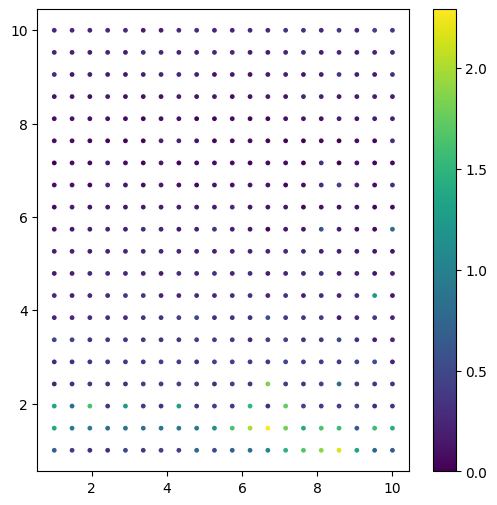

0.026674543189066834


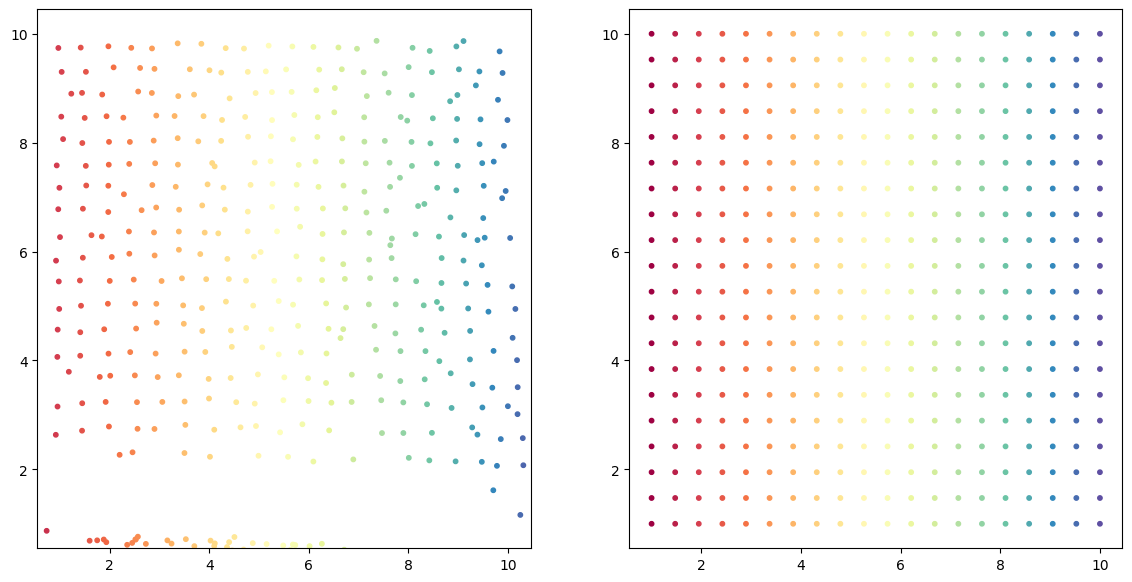

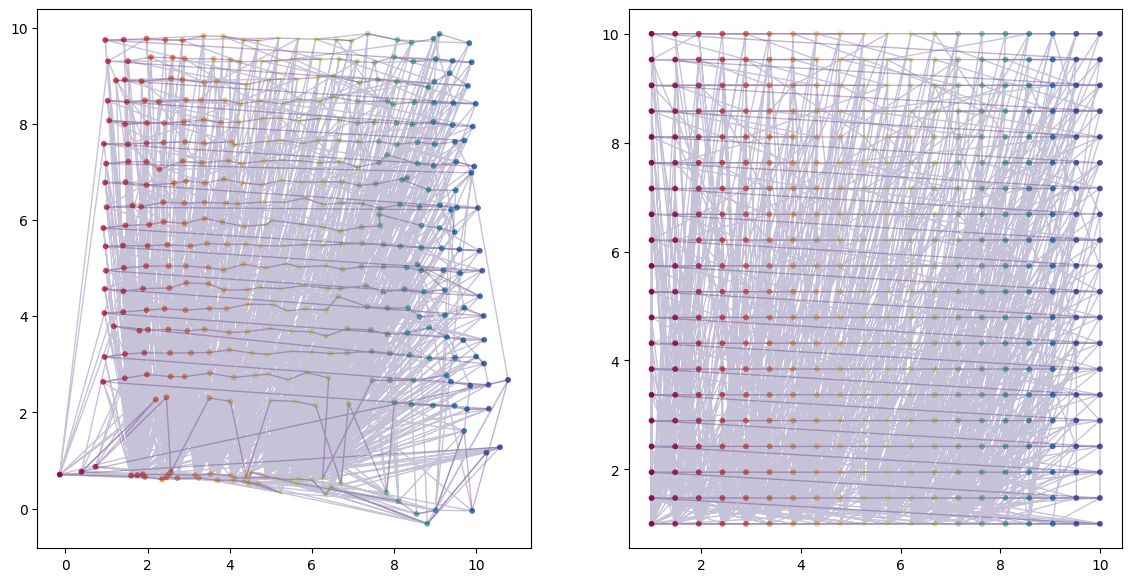

In [4]:
reload(mcu)
reload(cyl)
ld_embedding = mcu.reduce_dimensions(q)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1), reconstructed_y_to_params)
print(np.median(rre))
mcu.plot_two_embeddings(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

In [5]:
reload(cyl)
test_control_vars = cyl.get_random_control_vars(1000)
test_rolls = cyl.generate_array_of_cylinders(test_control_vars, noise_level=0.5, num_points=cylinder_point_cnt, random_scatter=True)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k)
    x_opt = x_opt * x_stds + x_means
    # x_err = 0
    # x_opt = (random.random()*10, random.random()*10)
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [8.36748507 4.6241772 ], x_err = 4.052941008745438e-14
x_real = [7.578711812659543, 3.730756368400656]
-----------
x_opt  = [4.78182655 4.67838549], x_err = 1.475625089370351e-14
x_real = [0.8683047302172198, 4.722809522425811]
-----------
x_opt  = [4.34852636 5.09977401], x_err = 2.4734371870259348e-14
x_real = [9.195957986836143, 3.2100108013299877]
-----------
x_opt  = [7.43367052 8.95127273], x_err = 4.600203494844868e-15
x_real = [1.3145956369897094, 9.778548139974559]
-----------
x_opt  = [1.94918467 2.6295367 ], x_err = 3.307972214080018e-14
x_real = [2.9939197886728564, 0.8004436689390448]
-----------
x_opt  = [2.14615948 6.78089743], x_err = 1.1041768294351854e-15
x_real = [3.7467745451191217, 6.429672510292551]
-----------
x_opt  = [9.05081533 9.05081533], x_err = 23.813639675824422
x_real = [9.615549892784369, 9.206830491956715]
-----------
x_opt  = [6.1405761  6.11951999], x_err = 2.3275240379075182e-14
x_real = [5.432866016663498, 5.6626198229453095]
-

[1.19179027 3.91377395 5.20276833 6.17474388 2.10643129 1.6386969
 0.58588895 0.84238431 2.36819967 4.26349022 1.00801439 2.21788399
 2.5038519  6.52977207 3.62867236 2.920438   4.86984772 3.85156706
 4.54673285 5.30782243 5.16806485 1.20740515 0.40682085 3.16566471
 1.3850499  7.52237778 4.7218385  6.5372982  5.3685468  2.98373232
 6.24509603 3.30866267 5.20299275 5.58479601 0.88135058 1.48200823
 3.54204011 1.94554464 7.22683396 2.74277973 4.62366893 3.7881314
 3.34298648 1.70204969 6.00050791 5.33800927 0.51505993 1.52070225
 7.23976189 4.73672426 1.73020781 3.64865777 3.31519639 3.84187843
 2.38645677 2.25672466 0.3428526  5.0911301  2.03249868 3.54470896
 7.30442488 5.9532493  6.39726131 2.02572801 2.58810459 1.65885402
 7.88891387 1.91956682 6.76427307 1.53858377 0.79541302 0.14614808
 2.39688355 2.84258622 0.6413055  3.48034115 1.16746103 7.18298381
 3.90192609 4.55527418 1.27719304 0.22232067 2.89500785 1.70731582
 1.87815947 1.51656101 5.58225302 5.8797331  5.50624326 1.601182

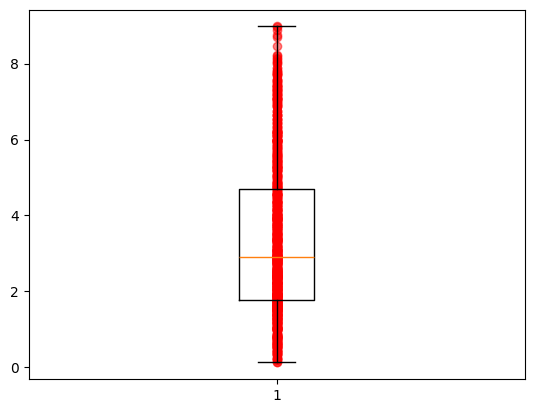

In [6]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")

In [7]:
reload(cyl)
test_control_vars = cyl.get_random_control_vars(1000)
test_rolls = cyl.generate_array_of_cylinders(test_control_vars, noise_level=0.5, num_points=cylinder_point_cnt, random_scatter=False)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k)
    x_opt = x_opt * x_stds + x_means
    # x_err = 0
    # x_opt = (random.random()*10, random.random()*10)
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [3.48453473 6.25297572], x_err = 1.21898607203412e-15
x_real = [8.264197425834718, 5.291928177030258]
-----------
x_opt  = [9.05081533 9.05081533], x_err = 64.21278814659827
x_real = [6.6473906998143715, 9.819020949001509]
-----------
x_opt  = [5.50715498 6.51110021], x_err = 8.824959014979829e-15
x_real = [7.115313207034367, 5.721166999247394]
-----------
x_opt  = [3.59137491 2.81606512], x_err = 1.2735399041217875e-14
x_real = [1.2268133439084283, 2.2386691547661353]
-----------
x_opt  = [4.05683069 6.32962841], x_err = 2.1456953906332824e-14
x_real = [9.889747335986709, 5.407850785122639]
-----------
x_opt  = [5.2310047  6.86672945], x_err = 2.5000492600531844e-14
x_real = [2.948148942921489, 6.897307988851088]
-----------
x_opt  = [4.57682745 6.6053612 ], x_err = 3.474691536997469e-14
x_real = [6.651778885854976, 5.908627466342535]
-----------
x_opt  = [9.05081533 3.54890948], x_err = 4.540924257533782e-14
x_real = [9.211985523711302, 0.019833422323444205]
----

In [ ]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")